In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, img_to_array 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model,Sequential, model_from_json
from keras.initializers import glorot_uniform
import cv2
import dlib
from PIL import Image
from skimage import transform
from sklearn.model_selection import train_test_split 
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.regularizers import l2
from keras.optimizers import Adam
import json
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv('fer2013/fer2013.csv')

In [3]:
df.info

<bound method DataFrame.info of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 col

In [3]:
print(df.groupby('emotion').agg('count'))
df.drop(df[df['emotion']==1].index, inplace=True)

pixels  Usage
emotion               
0          4953   4953
1           547    547
2          5121   5121
3          8989   8989
4          6077   6077
5          4002   4002
6          6198   6198


In [4]:
df['emotion'] = df['emotion'] - 1

In [5]:
df.groupby('emotion').agg('count')

,pixels,Usage
emotion,,
-1,4953,4953
1,5121,5121
2,8989,8989
3,6077,6077
4,4002,4002
5,6198,6198


In [6]:
df.loc[df['emotion']==-1,'emotion'] = 0

In [7]:
df.groupby('emotion').agg('count')


,pixels,Usage
emotion,,
0,4953,4953
1,5121,5121
2,8989,8989
3,6077,6077
4,4002,4002
5,6198,6198


In [8]:
datapoints = df['pixels'].tolist()
X_train = []
for x in datapoints:
    X = [int(i) for i in x.split(' ')]
    X = np.asarray(X).reshape(48,48)
    X_train.append(X.astype('float32'))
X_train = np.asarray(X_train)
X_train = np.expand_dims(X_train, -1)
Y_train = pd.get_dummies(df['emotion']).as_matrix() 

[0 0 0 0 0 1]


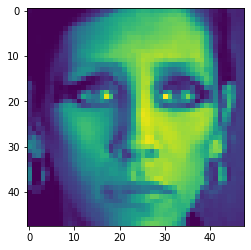

In [9]:
x = X_train[4]
x = x.reshape((48,48))
plt.imshow(x)
print(Y_train[4])

In [10]:
X_train/=255.0
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1)   

In [11]:
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid, Y_valid, test_size=0.5)

In [12]:
print("Train Shape : {}".format(X_train.shape))
print("Train Shape : {}".format(Y_train.shape))
print("Valid Shape : {}".format(X_valid.shape))
print("Valid Shape : {}".format(Y_valid.shape))
print("Test Shape : {}".format(X_test.shape))
print("Test Shape : {}".format(Y_test.shape))

Train Shape : (31806, 48, 48, 1)
Train Shape : (31806, 6)
Valid Shape : (1767, 48, 48, 1)
Valid Shape : (1767, 6)
Test Shape : (1767, 48, 48, 1)
Test Shape : (1767, 6)


In [2]:
def model_arch() :
    input_X = Input((48,48,1))
    # START
    conv_1 = Conv2D(64,(7,7),strides=(2,2),activation='relu')(input_X)
    pool_1 = MaxPooling2D((3,3),strides=(2,2))(conv_1)
    lrn_1 = keras.layers.BatchNormalization()(pool_1)

    #FEAT-EX1
    conv_2a = Conv2D(96,(1,1),strides=(1,1),activation='relu')(lrn_1)
    conv_2b = Conv2D(208,(1,1),strides=(1,1),activation='relu')(conv_2a)
    pool_2a = MaxPooling2D((3,3),strides=(1,1),padding='same')(lrn_1)
    conv_2c = Conv2D(64,(1,1),strides=(1,1),activation='relu')(pool_2a)
    concat2 = keras.layers.concatenate(inputs=[conv_2b,conv_2c], axis=3)
    pool_2b = MaxPooling2D((3,3),strides=(2,2))(concat2)

    #FEAT-X2
    conv_3a = Conv2D(96,(1,1),strides=(1,1),activation='relu')(pool_2b)
    conv_3b = Conv2D(96,(1,1),strides=(1,1),activation='relu')(conv_3a)
    pool_3a = MaxPooling2D((3,3),strides=(1,1),padding='same')(pool_2b)
    conv_3c  = Conv2D(64,(1,1),strides=(1,1),activation='relu')(pool_3a)
    concat3 = keras.layers.concatenate(inputs=[conv_3c,conv_3b], axis=3)
    pool_3b = MaxPooling2D((3,3),strides=(2,2))(concat3)

    out = Flatten()(pool_3b)
    out = Dense(6,activation='softmax')(out)

    model = Model(inputs=input_X, outputs = out)

    return model

In [3]:
def get_compiled_model():
    model = model_arch()
    model.compile(optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 21, 21, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 10, 10, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 10, 10, 64)   256         max_pooling2d_1[0][0]            
___________________________________________________________________________________________

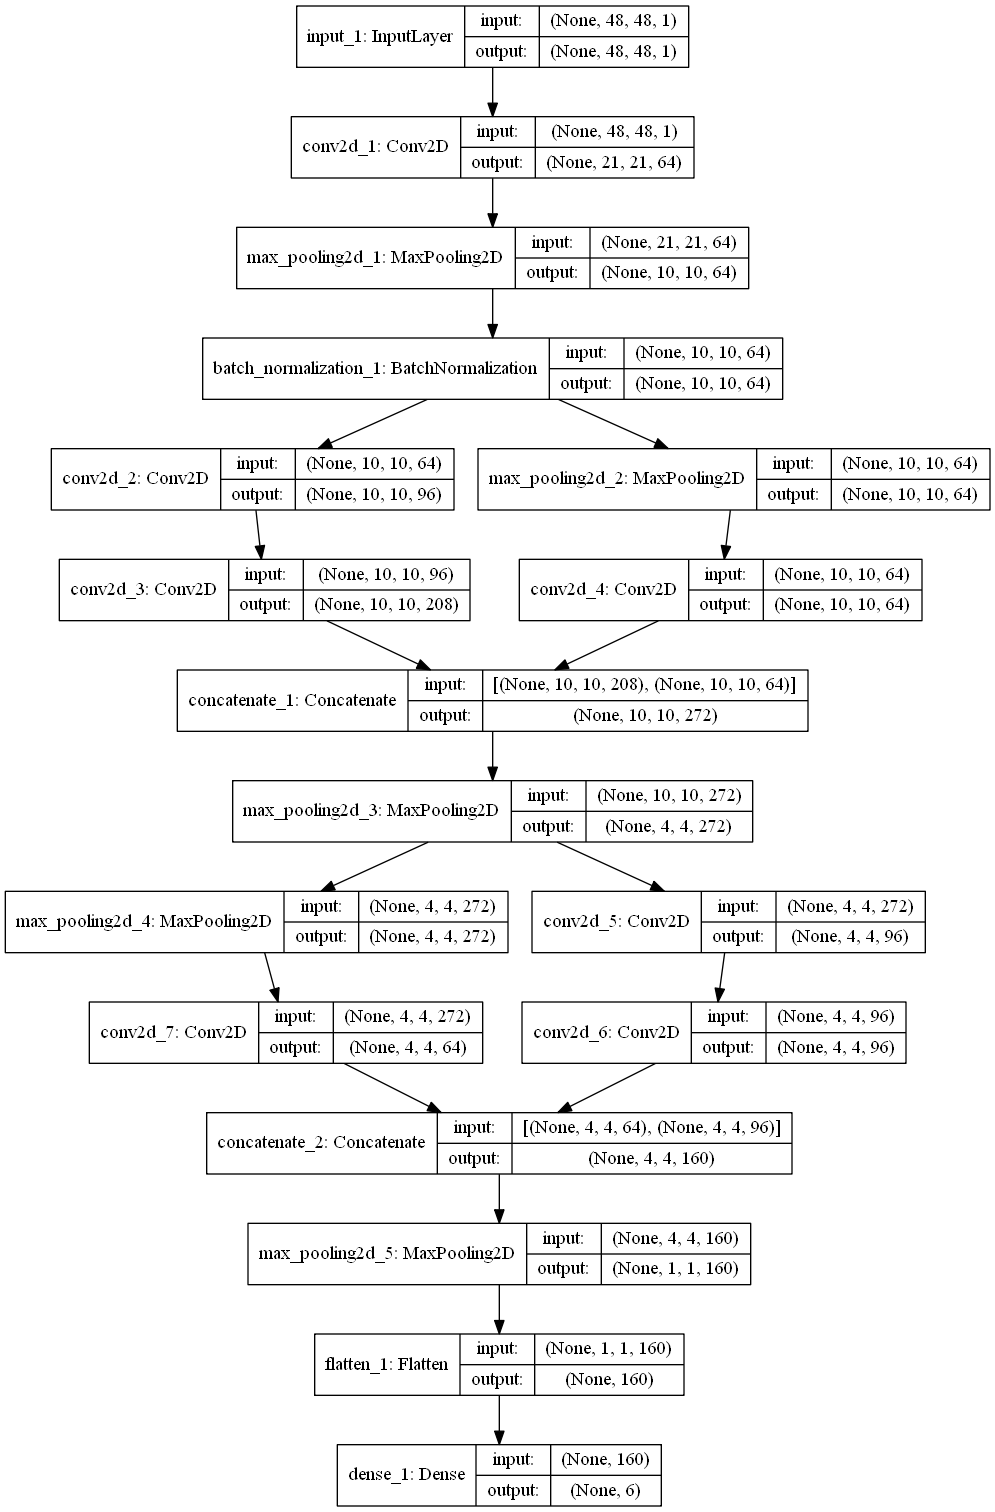

In [4]:
model = get_compiled_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train,Y_train,batch_size=64)
valid_generator = valid_datagen.flow(X_valid,Y_valid,batch_size=1)

In [21]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='model2/model_{epoch}_{val_loss}.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.9, patience = 3)
]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# print(STEP_SIZE_TRAIN,train_generator.n,train_generator.batch_size)
# print(STEP_SIZE_VALID,valid_generator.n,valid_generator.batch_size)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs=100,
    validation_data = valid_generator,
    validation_steps = STEP_SIZE_VALID,
    callbacks=callbacks
)

aving model to model2/model_1_1.8701410293579102.h5
Epoch 2/100
496/496 [==============================] - 17s 34ms/step - loss: 1.6695 - accuracy: 0.3002 - val_loss: 1.4330 - val_accuracy: 0.3350

Epoch 00002: val_loss improved from 1.87014 to 1.43298, saving model to model2/model_2_1.432979702949524.h5
Epoch 3/100
496/496 [==============================] - 16s 32ms/step - loss: 1.6182 - accuracy: 0.3303 - val_loss: 1.7061 - val_accuracy: 0.3418

Epoch 00003: val_loss did not improve from 1.43298
Epoch 4/100
496/496 [==============================] - 16s 33ms/step - loss: 1.5675 - accuracy: 0.3614 - val_loss: 1.5708 - val_accuracy: 0.1992

Epoch 00004: val_loss did not improve from 1.43298
Epoch 5/100
496/496 [==============================] - 17s 33ms/step - loss: 1.5316 - accuracy: 0.3821 - val_loss: 2.3529 - val_accuracy: 0.2575

Epoch 00005: val_loss did not improve from 1.43298
Epoch 6/100
496/496 [==============================] - 17s 35ms/step - loss: 1.4955 - accuracy: 0.4015 

In [37]:
def get_key(val): 
    d = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5: 'Neutral'}
    return d[val]

In [22]:
model.save('model_feat4.h5')

In [91]:
json_string = model.to_json()
with open("model_feat4.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('model_feat4_weights.h5')

In [90]:
model = load_model('model2\model_65_0.007784269750118256.h5')

In [23]:
net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")

In [85]:
def inference(image_path):
    frame = cv2.imread(image_path)
    (h,w) = frame.shape[:2]  
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300,300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    m=0
    for i in range(0,detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence < 0.5:
            continue    
        if(m < confidence):
            m = confidence
            pos = i       
            box = detections[0, 0, pos, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            image = frame[startY:endY, startX:endX]
    cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 2)
    cv2.imwrite('3.jpg',frame)
    # print(image.shape)
    # plt.imshow(image)
    face = cv2.cvtColor(cv2.resize(image,(48,48)), cv2.COLOR_BGR2GRAY)
    roi = face.astype("float")
    roi/=255.0
    roi = np.reshape(roi,(1,48,48,1))   
    pred = model.predict(roi)
    c = list(np.argmax(pred,axis=1))
    # print(c)
    return get_key(c[0]), image

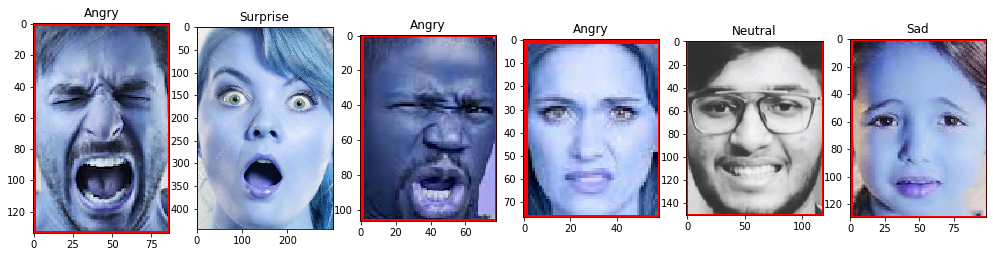

In [89]:
import os
n = len(os.listdir('testImages'))
fig = plt.figure(figsize=(20,20))
x = 1
plt.subplot()
for i in os.listdir('testImages'):
    label, im = inference(os.path.join('testImages',i))
    plt.subplot(1,n+1,x)
    plt.imshow(im)
    plt.title(label)
    x+=1
plt.show()